# Import libraries

In [1]:
import os
import logging

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages are logged (default), 1 = INFO, 2 = WARNING, 3 = ERROR
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import time  # Import the time module
import importlib.util

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from scipy.stats import t, entropy, stats

import tensorflow as tf
from tensorflow.keras import regularizers, Input, Model, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from k_means_constrained import KMeansConstrained

from helpers import (
    parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, 
    NW_risk_fun, square_risk_fun, map_to_color, simulate_quant_trait
)

from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

In [2]:
dict = parse_variables('geno_simulation.txt')
if 'G' not in globals():
    G = int(dict['G'])
if 'L' not in globals():
    L = int(dict['L'])
if 'c' not in globals():
    c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
if 'M' not in globals():
    M = float(dict['M'])
if 'HWE' not in globals():
    HWE = int(dict['HWE'])

if 'bottleneck_nr' not in globals():
    bottleneck_nr = int(dict['bottleneck_nr'])

if 'nr_humans' not in globals():
    nr_humans = int(dict['nr_humans'])

if 'nr_snps' not in globals():
    nr_snps = int(dict['nr_snps'])

if 'epoch' not in globals():
    epoch = 500
if 'patience' not in globals():
    patience = 100

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = int((G*L)/2)
number_of_individuals = c*k*k

In [3]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [4]:
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load populations

In [5]:
"""
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
#plt.show()
plt.close()
"""

'\npopulations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")\npopulations[\'population_number\'] = populations[\'populations\'].str.extract(\'(\\d+)\').astype(int)\n# Calculating X and Y coordinates\npopulations[\'x\'] = ((populations[\'population_number\'] - 1) % k) + 1\npopulations[\'y\'] = ((populations[\'population_number\'] - 1) // k) + 1\npopulations[\'z\'] = 0.5\npopulations[\'population\'] = populations[\'population_number\']/(k*k)\npalette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations[\'x\'], populations[\'y\'], populations[\'z\'])]\n\n# Standardize the vector\nstd_dev = np.std(populations[\'x\'])\nmean = np.mean(populations[\'x\'])\npopulations[\'x\'] = np.round((populations[\'x\'] - mean) / std_dev,2)\n\nstd_dev = np.std(populations[\'y\'])\nmean = np.mean(populations[\'y\'])\npopulations[\'y\'] = np.round((populations[\'y\'] - mean) / std_dev,2)\n\n# Check the grid\ndf_agg = populations.groupby([\'x\

# Run abyss on everything

In [6]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(100, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        tf.keras.layers.Dense(geno_out.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

# Function to ensure minimum cluster size
def ensure_min_cluster_size(data, labels, min_size):
    unique_labels, counts = np.unique(labels, return_counts=True)
    small_clusters = unique_labels[counts < min_size]
    
    # Reassign points from small clusters to the nearest large cluster
    for cluster in small_clusters:
        indices = np.where(labels == cluster)[0]
        for index in indices:
            # Find nearest large cluster
            nearest_large_cluster = None
            nearest_distance = float('inf')
            for label in unique_labels:
                if label not in small_clusters:
                    distance = np.linalg.norm(data.iloc[index] - kmeans.cluster_centers_[label])
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_large_cluster = label
            labels[index] = nearest_large_cluster
    
    return labels

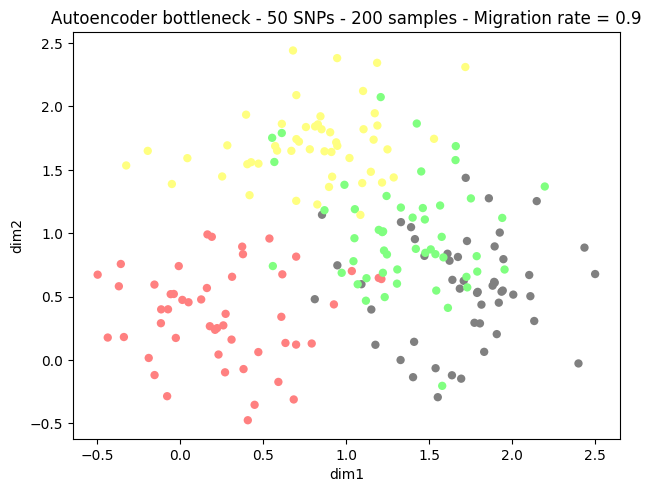

Time taken: 23.567 seconds


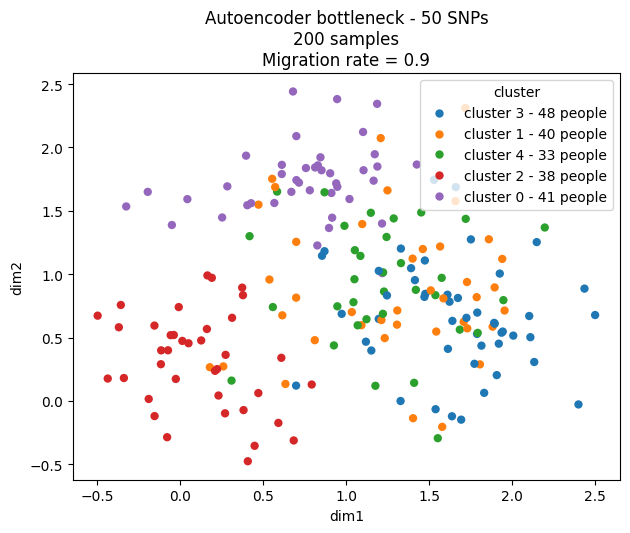

In [7]:
if 'abyss' in tools:
    dim_labels = [f"dim{i}" for i in range(1, 2 + 1)]
    autoencoder, bottleneck_model, history = abyss(complete, complete, 2, epoch, patience)
    bottle_2dim = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)
    path_plots = f"data/results/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/plots/"
    os.makedirs(path_plots, exist_ok=True)


    populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")
    colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
    sns.scatterplot(x='dim1', y='dim2', data=bottle_2dim, color=colors, linewidth=0)
    
    # Adjust layout
    plt.tight_layout()
    plt.title(f"Autoencoder bottleneck - {number_of_snps} SNPs - {number_of_individuals} samples - Migration rate = {M}")
    # Show the plots
    plt.savefig(f"{path_plots}/bottleneck.png", dpi=100)
    plt.show()
    plt.close()


    dim_labels = [f"dim{i}" for i in range(1, bottleneck_nr + 1)]
    # start timer
    start_time = time.time()
    autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)
    # end timer
    end_time = time.time()
    
    # Calculate the elapsed time
    elapsed_time = np.round(end_time - start_time,3)
    print(f"Time taken: {elapsed_time} seconds")

    bottle = pd.DataFrame(data=bottleneck_model(complete), columns = dim_labels)

    sample_size = nr_humans
    
    num_clus = round(len(bottle) / sample_size)+1
    
    size_clus = int(len(bottle)/num_clus)
    size_min = size_clus - round(size_clus / 5)
    size_max = size_clus + round(size_clus / 5)
    if num_clus <= 1:
        bottle['cluster'] = 0
    else:
        # Apply constrained K-Means clustering
        clf = KMeansConstrained(
            n_clusters=num_clus,
            size_min=size_min,
            size_max=size_max,
            random_state=0
        )
        clf.fit_predict(np.array(bottle))
        bottle['cluster'] = clf.labels_

    # If you want to shuffle instead of cluster
    """
    # Assign cluster labels to genotypic data
    count = Counter(clf.labels_)
    empty = []
    sample_size_temp = floor(len(clf.labels_)/sample_size)
    for val in count.values():
        multi = floor(val/sample_size_temp)+1
        list_to_sample = multi*list(range(sample_size_temp))
        random.shuffle(list_to_sample)
        empty = empty + list_to_sample[0:val]
    
    bottle['cluster'] = empty
    """


    bottle_2dim['cluster'] = bottle['cluster']
    bottle_2dim
    cluster_counts = bottle_2dim['cluster'].value_counts()
    
    # Step 2: Update the 'cluster' column with the desired format
    bottle_2dim['cluster'] = bottle_2dim['cluster'].apply(lambda x: f"cluster {x} - {cluster_counts[x]} people")

    sns.scatterplot(x='dim1', y='dim2', data=bottle_2dim, hue='cluster', linewidth=0)
    
    # Adjust layout
    plt.tight_layout()
    plt.title(f"Autoencoder bottleneck - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate = {M}")
    # Show the plots
    plt.savefig(f"{path_plots}/clustering.png", dpi=100)
    plt.show()


    path_bottle = f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/abyss_bottleneck"
    os.system(f"rm -rf {path_bottle}")
    os.makedirs(path_bottle, exist_ok=True)

    bottle.to_pickle(f"{path_bottle}/abyss_bottleneck_{bottleneck_nr}_{elapsed_time}seconds.pkl")

else:
    pass